# Estimation of flight delays

### Data exploration

#### Loading dataset

In [33]:
import pandas as pd

data = pd.read_csv('data/dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'])


bStart, bEnd = ['\x1b[1;30m','\x1b[0m']
print('Size of the dataset '+bStart+'N:',data.shape[0],bEnd)

print(bStart+'Features ('+str(data.shape[1])+'): '+bEnd+'\n\t -'+'\n\t -'.join(data.columns))

Size of the dataset N: 68206 
Features (18): 
	 -Fecha-I
	 -Vlo-I
	 -Ori-I
	 -Des-I
	 -Emp-I
	 -Fecha-O
	 -Vlo-O
	 -Ori-O
	 -Des-O
	 -Emp-O
	 -DIA
	 -MES
	 -AÑO
	 -DIANOM
	 -TIPOVUELO
	 -OPERA
	 -SIGLAORI
	 -SIGLADES


In [35]:
import numpy as np

compareData = ['Vlo', 'Ori', 'Des']

for comp in compareData:
    comparison = data[comp+'-I'] != data[comp+'-O']

    if comparison.any():
        print(comp+' differs '+bStart+str(sum(comparison))+bEnd+' times, at:')
        print(np.where(comparison))
    else:
        print(comp+' do not differ')

Vlo differs 1850 times, at:
(array([ 6018,  6020,  6022, ..., 65534, 65535, 68068]),)
Ori do not differ
Des differs 28 times, at:
(array([ 1397,  7290,  7520,  8456, 12787, 12823, 16169, 16937, 18293,
       20444, 24569, 25419, 25422, 25492, 33166, 37162, 38094, 38135,
       38136, 39265, 42112, 55144, 61463, 62651, 67599, 67600, 67601,
       67697]),)


#### Plotting data

Following plots show distributions of a subset of the data.

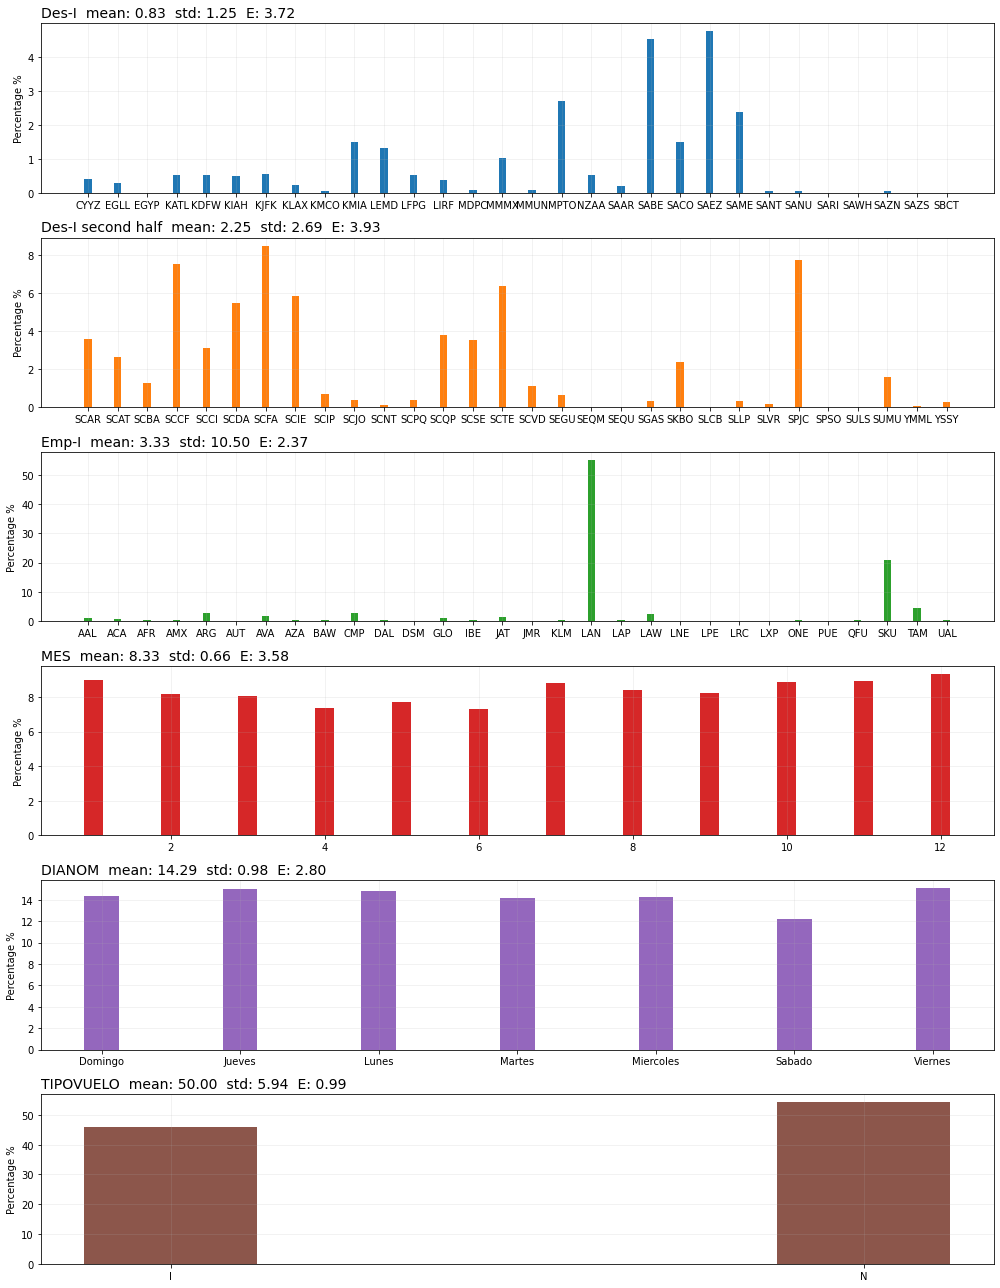

In [57]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

toShow = ['Des-I', 'last-Des-I', 'Emp-I', 'MES', 'DIANOM', 'TIPOVUELO']
nPlots = len(toShow)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

total = data.shape[0]
usePercentage = True

for col,ax,color in zip(toShow,axs,colors):
    if 'last-' in col:
        col = col.replace('last-','')
        title = col + ' second half'
        vCounts = data[col].value_counts().sort_index()[-30:]
    else:
        title = col
        vCounts = data[col].value_counts().sort_index()[:30]
    cat = vCounts.index
    count = 100.0*vCounts.values/total if usePercentage else vCounts.values
    m,s = [np.mean(count),np.std(count,ddof=1)]
    E = entropy(vCounts.values/total, base=2)
    # sem = s/np.sqrt(total)
    title = title+'  mean: '+f'{m:.2f}'+'  std: '+f'{s:.2f}'+'  E: '+f'{E:.2f}'
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Percentage %' if usePercentage else 'Counts #')
    ax.grid(alpha=0.2)

plt.tight_layout()

From the data, it can be extracted that:
  - Destinations are widely varied, being a potentially informative variable (it has the greatest entropy).
  - Managing companies show a spare distribution, LAN managed more than 50% of the flights. 
  - Data from MES, DIANOM, and TIPOVUELO have a more flat distributions, meaning that they can also be informative.

#### Creating synthetic features

In [4]:
from datetime import date as dt

highSeasons = [[dt(2016,12,15),dt(2017,3,3)],
               [dt(2017,7,15),dt(2017,7,31)],
               [dt(2017,9,11),dt(2017,9,30)],
               [dt(2017,12,15),dt(2018,3,3)]]

newFeatures = {'temporada_alta': np.full((total,),False)}
for hS in highSeasons:
    fI = data['Fecha-I'].dt.date
    newFeatures['temporada_alta'] |= ((fI >= hS[0]) & (fI <= hS[1]))

newFeatures['dif_min'] = (data['Fecha-O']-data['Fecha-I'])/pd.Timedelta(minutes=1)
newFeatures['atraso_15'] = newFeatures['dif_min'] > 15

hours = data['Fecha-I'].dt.hour
newFeatures['periodo_dia'] = np.full((total,),'      ')
newFeatures['periodo_dia'][(hours >=5) & (hours < 12)] = 'mañana'
newFeatures['periodo_dia'][(hours >=12) & (hours < 19)] = 'tarde'
newFeatures['periodo_dia'][(hours >=19) | (hours < 5)] = 'noche'

newFeatures = pd.DataFrame.from_dict(newFeatures)
newFeatures['temporada_alta'] = newFeatures['temporada_alta'].astype(int)
newFeatures['atraso_15'] = newFeatures['atraso_15'].astype(int)
newFeatures.to_csv('synthetic_features.csv')

### Plotting delay distributions

Following 

Total delays (>= 15 min):  12614 


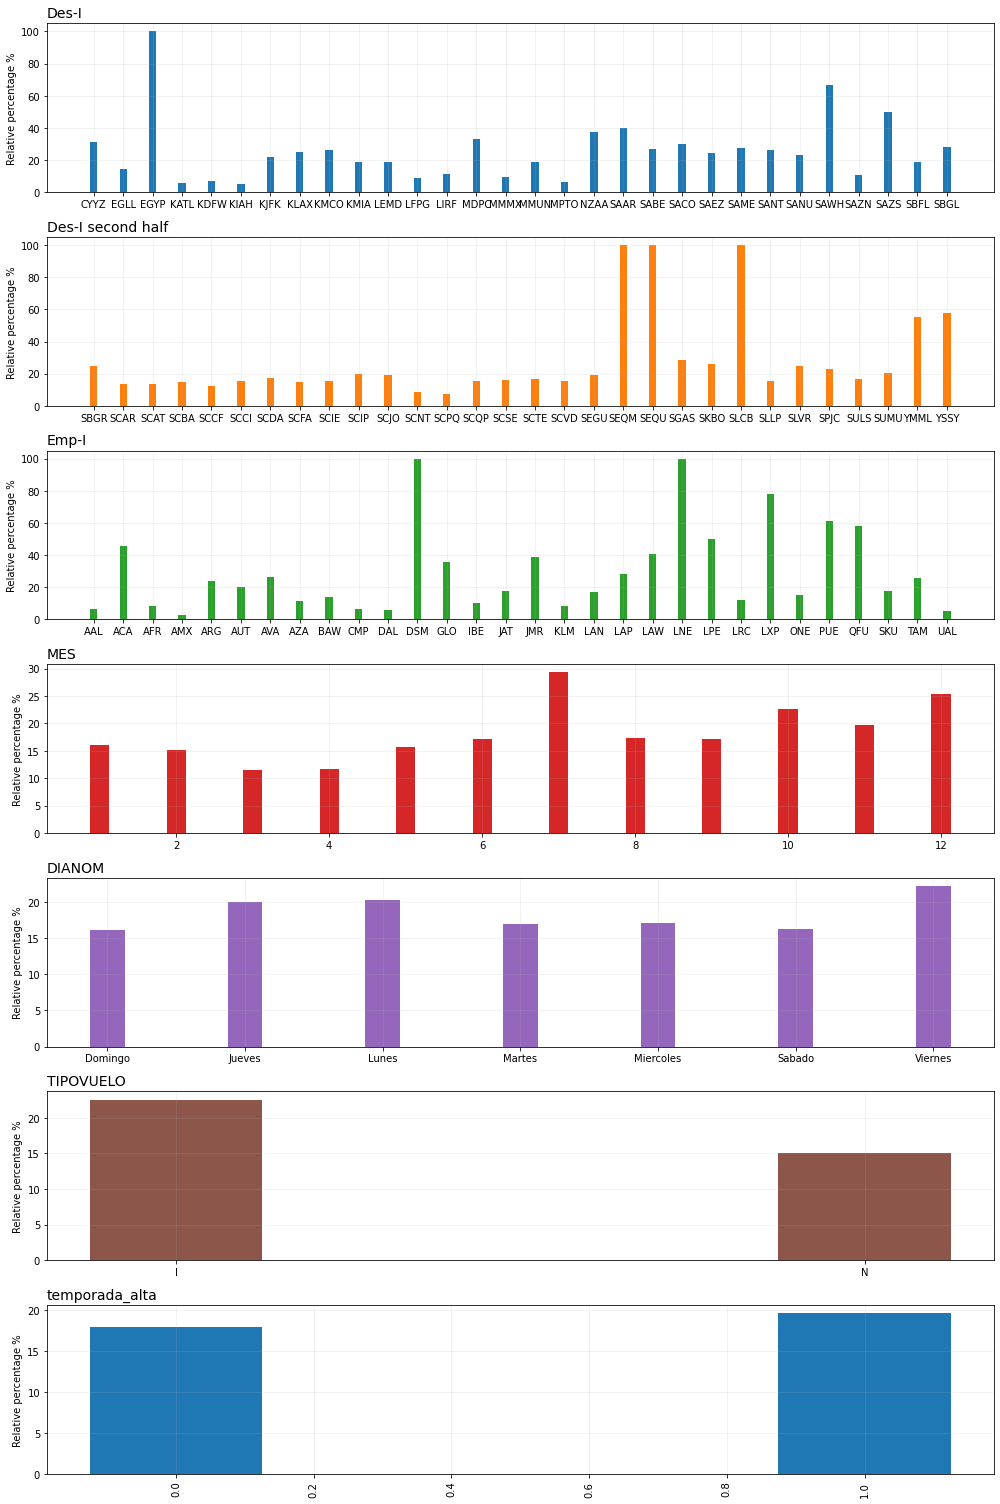

In [55]:
toCompare = {'data':      ['Des-I', 'last-Des-I', 'Emp-I', 'MES', 'DIANOM', 'TIPOVUELO'], 
             'synthetic': ['temporada_alta']
            }

nPlots = len(toCompare['data'])+len(toCompare['synthetic'])
fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

usePercentage = True
total = sum(newFeatures['atraso_15'] > 0)
print('Total delays (>= 15 min):',bStart,total,bEnd)

for col,ax,color in zip(toCompare['data'],axs,colors):
    if 'last-' in col:
        col = col.replace('last-','')
        title = col + ' second half'
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[-30:]
    else:
        title = col
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[:30]
    cat = vCounts.index
    count = [100.0*vCounts.values[i]/sum(data[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    plt.xticks(rotation=90)
    ax.grid(alpha=0.2)

for col,ax,color in zip(toCompare['synthetic'],[axs[-1]],colors):
    vCounts = newFeatures[col][newFeatures['atraso_15'] > 0].value_counts()
    cat = vCounts.index
    total = newFeatures[col]
    count = [100.0*vCounts.values[i]/sum(newFeatures[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(col,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    plt.xticks(rotation=90)
    ax.grid(alpha=0.2)
plt.tight_layout()

The rate of delay over each feature shows that:
  - Some destinations are highly determinant as their relative rate of delay is 100% (all flights to those destinations were delay).
  - The same happend with managing companies.
  
 This may imply that those variables can be highly informative, but it is important to know if those destinations and companies, the ones with expected delays, have a relative high use (with respect to the others). If they are not common destinations nor used companies, then those features wont be as informative as expected.
 
The following plots show their delay rate wheighted by their relative use.

Total delays (>= 15 min):  12614 


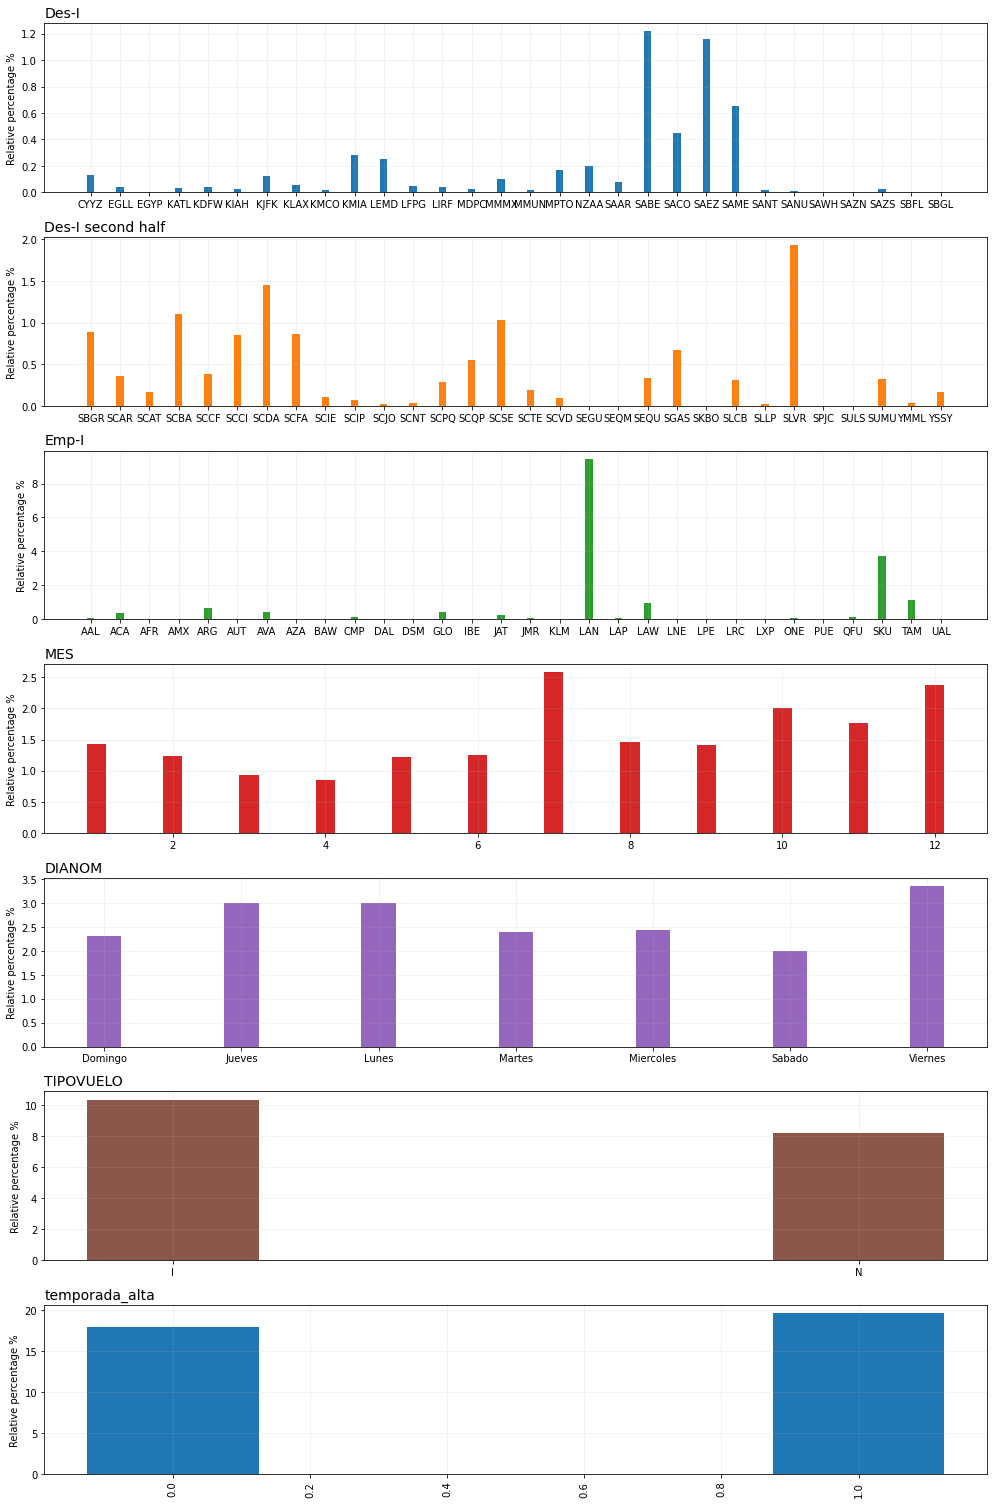

In [58]:
toCompare = {'data':      ['Des-I', 'last-Des-I', 'Emp-I', 'MES', 'DIANOM', 'TIPOVUELO'], 
             'synthetic': ['temporada_alta']
            }

nPlots = len(toCompare['data'])+len(toCompare['synthetic'])
fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

usePercentage = True
total = sum(newFeatures['atraso_15'] > 0)
N = data.shape[0]
print('Total delays (>= 15 min):',bStart,total,bEnd)

for col,ax,color in zip(toCompare['data'],axs,colors):
    if 'last-' in col:
        col = col.replace('last-','')
        title = col + ' second half'
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[-30:]
        catCount = data[col].value_counts().sort_index()[-30:]
    else:
        title = col
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[:30]
        catCount = data[col].value_counts().sort_index()[:30]
    cat = vCounts.index
    count = [(catCount.values[i]/N)*100.0*vCounts.values[i]/sum(data[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    plt.xticks(rotation=90)
    ax.grid(alpha=0.2)

for col,ax,color in zip(toCompare['synthetic'],[axs[-1]],colors):
    vCounts = newFeatures[col][newFeatures['atraso_15'] > 0].value_counts()
    cat = vCounts.index
    total = newFeatures[col]
    count = [100.0*vCounts.values[i]/sum(newFeatures[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(col,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    plt.xticks(rotation=90)
    ax.grid(alpha=0.2)
plt.tight_layout()

The relative use of the most certainly delayed companies and destinations highly reduced the impact of those variables.

Then, it is expected that the combination of the relevant variables (destination, company)